# Parallel execution

In this tutorial, we will see how to efficiently run simulations of the model for a batch of different initial conditions, in a vectorized manner using JAX `vmap` transformation. 
We will use it to visualize, in phase space, the trajectories of [this SBML model](https://www.ebi.ac.uk/biomodels/BIOMD0000000156) starting from a grid of different initial conditions.
As you will see, vectorizing the model will require only few lines of code.

## Imports and Utils

In [1]:
import importlib
from itertools import combinations

import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
from jax import vmap

import matplotlib.pylab as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.transforms import Affine2D, offset_copy
from sbmltoodejax.utils import load_biomodel

In [2]:
# Plot Utils
default_colors = [(204,121,167), 
                  (0,114,178),
                  (230,159,0),  
                  (0,158,115),
                  (127,127,127),
                  (240,228,66),
                  (148,103,189),
                  (86,180,233),
                  (213,94,0),
                  (140,86,75),
                  (214,39,40),
                  (0,0,0)]
default_colors = [tuple([c/255 for c in color]) for color in default_colors]

def plot_time_trajectory(ts, ys, y_indexes):
    plt.figure(figsize=(6, 4))
    for y_label, y_idx in y_indexes.items():
        plt.plot(ts, ys[y_idx, :], color=default_colors[y_idx], label=y_label)
    plt.legend()
    plt.show()
    
def plot_phase_space_trajectories(ys, y_indexes, plot_every=1):

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    
    # plot trajectories
    X = ys[..., 0, :-1][..., ::plot_every]
    Y = ys[..., 1, :-1][..., ::plot_every]
    Z = ys[..., 2, :-1][..., ::plot_every]
    U = ys[..., 0, 1:][..., ::plot_every] - X
    V = ys[..., 1, 1:][..., ::plot_every] - Y
    W = ys[..., 2, 1:][..., ::plot_every] - Z
    
    T = X.shape[-1]
    if X.ndim == 2:
        batch_size = X.shape[0]
    else:
        batch_size = 1
    c = ([hsv_to_rgb((step / (2*T), 1, 1)) for step in range(T)][::plot_every])*batch_size
    ax.quiver(X.flatten(), Y.flatten(), Z.flatten(), 
              U.flatten(), V.flatten(), W.flatten(), 
              color=c, arrow_length_ratio=0)
    
    # plot starting points
    ax.scatter(ys[..., 0, 0], ys[..., 1, 0], ys[..., 2, 0], color="red")

    for y_name, y_idx in y_indexes.items():
        if y_idx == 0:
            ax.set_xlabel(y_name)
        elif y_idx == 1:
            ax.set_ylabel(y_name)
        elif y_idx == 2:
            ax.set_zlabel(y_name)
    plt.show()

In [3]:
# Logo utils

## Taken from https://matplotlib.org/stable/gallery/text_labels_and_annotations/rainbow_text.html
def rainbow_text(x, y, strings, colors, orientation='horizontal', ax=None, **kwargs):
    """
    Take a list of *strings* and *colors* and place them next to each
    other, with text strings[i] being shown in colors[i].

    Parameters
    ----------
    x, y : float
        Text position in data coordinates.
    strings : list of str
        The strings to draw.
    colors : list of color
        The colors to use.
    orientation : {'horizontal', 'vertical'}
    ax : Axes, optional
        The Axes to draw into. If None, the current axes will be used.
    **kwargs
        All other keyword arguments are passed to plt.text(), so you can
        set the font size, family, etc.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    fig = ax.figure
    canvas = fig.canvas

    assert orientation in ['horizontal', 'vertical']
    if orientation == 'vertical':
        kwargs.update(rotation=90, verticalalignment='bottom')

    for s, c in zip(strings, colors):
        text = ax.text(x, y, s + " ", color=c, transform=t, **kwargs)

        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        # Convert window extent from pixels to inches
        # to avoid issues displaying at different dpi
        ex = fig.dpi_scale_trans.inverted().transform_bbox(ex)

        if orientation == 'horizontal':
            t = text.get_transform() + \
                offset_copy(Affine2D(), fig=fig, x=ex.width*0.65, y=0)
        else:
            t = text.get_transform() + \
                offset_copy(Affine2D(), fig=fig, x=0, y=ex.height)

def generate_logo(ts, y1, y2):
    T = len(ts)
    c = [hsv_to_rgb((step / (2*T), 1, 1)) for step in range(T)]
    x = y1[:-1]
    y = y2[:-1]
    u = y1[1:] - x
    v = y2[1:] - y
    fig = plt.figure(figsize=(7,4))
    plt.quiver(x, y, u, v, color=c, alpha=.7, angles='xy', scale_units='xy', scale=1, headaxislength=2)
    text_colors = [c[pos] for pos in range(0, len(c)//2, len(c)//len("SBML to ODE jax")//2)][::-1]
    rainbow_text(0.405, 0.35, [c for c in "SBML to ODE jax"[:11]], text_colors[:11], orientation='horizontal', size=20, weight="heavy")
    rainbow_text(0.5, 0.25, [c for c in "SBML to ODE jax"[11:]], text_colors[11:], orientation='horizontal', size=20, weight="heavy")
    plt.axis("off")
    plt.show()

## Running the default trajectory in phase space 

In [4]:
# Load model
model_idx = 156
model, default_y0, default_w0, default_c = load_biomodel(model_idx)

In [5]:
# Run simulation
n_secs = 100
default_ys, default_ws, ts = model(n_secs)

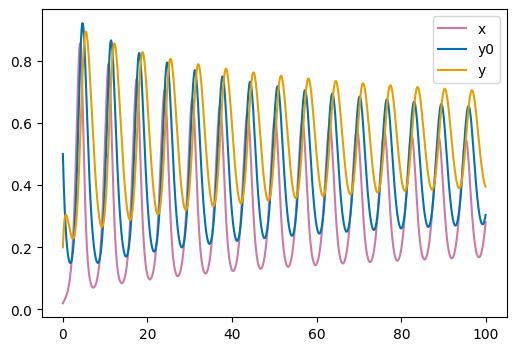

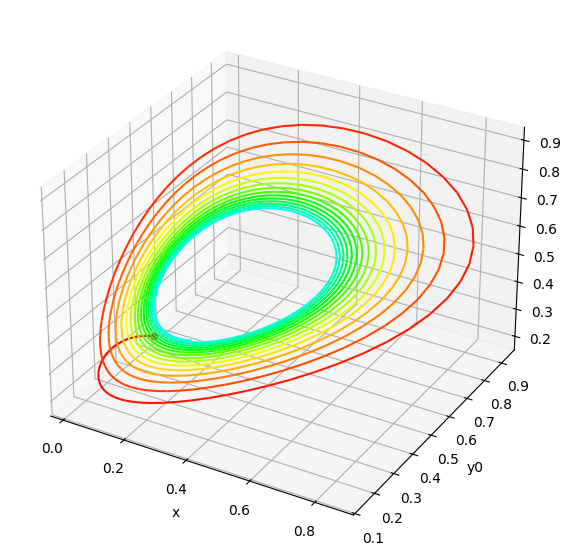

In [6]:
# Plot time-course evolution and corresponding trajectories in phase space
plot_time_trajectory(ts, default_ys, model.y_indexes)
plot_phase_space_trajectories(default_ys, model.y_indexes)

The model only has 3 nodes $(x, y0, y)$. 
Top plot shows the time-course evolution of the node states over time, and bottom plot shows the same trajectory in phase space.
Here the trajectory starts from the default initial conditions provided in the original SBML file: $(x=0.02, y0=0.5, y=0.2)$.
Colorscale in phase-space displays time evolution from t=0 (red) to t=100 secs (cyan).

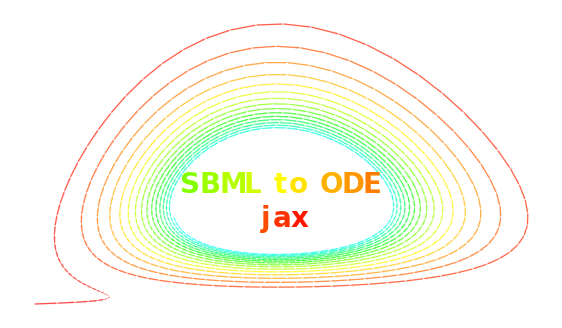

In [7]:
generate_logo(ts, default_ys[2], default_ys[0])

## Running simulation in batch mode, for a grid of different starting conditions

This time we want to run the model starting from a grid of 4x4x4 initial conditions. 
Let's start by creating a `batched_y0` vector that contains the different starting points (flatten grid of initial conditions).

In [8]:
# batch y0 
r=5
ymin = 1/r * default_ys.min(-1)
ymax = r * default_ys.max(-1)
n_inits_per_dim = 4
grid = jnp.meshgrid(
    *[
        jnp.linspace(ymin[node_idx], ymax[node_idx], n_inits_per_dim)
        for node_idx in range(len(ymin))
    ]
)
batched_y0 = jnp.stack([dim_grid.flatten() for dim_grid in grid], axis=-1)

Then, to run the model in a vectorized manner from this batch of initial conditions, one simply needs to vectorize the model function with JAX `vmap` transformation,
and then calling this vectorized function in the exact same way as before:

In [9]:
# batch model
batched_model = vmap(model, in_axes=(None, 0), out_axes=(0, 0, None))

# run simulation in batch mode
batched_ys, batched_ws, ts = batched_model(n_secs, batched_y0)

We can then run the resulting trajectories in phase space to observe the behaviors. Here we can see that all trajectories converge to the same orbit, despite starting from different positions.

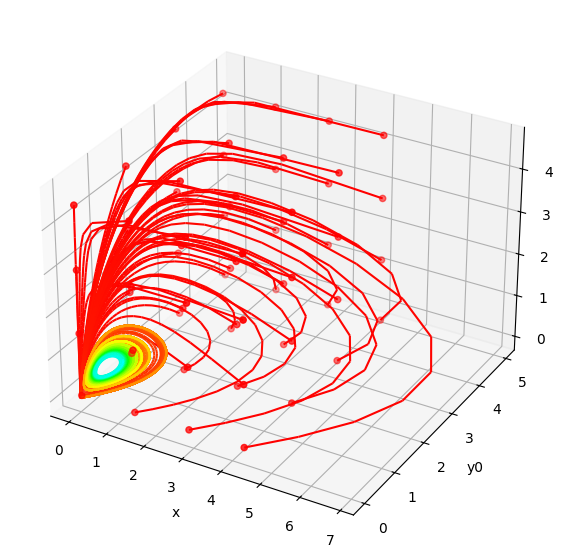

In [11]:
plot_phase_space_trajectories(batched_ys, model.y_indexes)